In [1]:
import uproot
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import yahist
import itertools

plt.rcParams.update({
    "figure.facecolor":  (1,1,1,0),  # red   with alpha = 30%
#     "axes.facecolor":    (1,1,1,0),  # green with alpha = 50%
#     "savefig.facecolor": (1,1,1,0),  # blue  with alpha = 20%
})


from utils.analysis import Optimization

TAG = "pku"

In [2]:
presort_babies = glob.glob(f"../analysis/studies/vbswh/output_{TAG}/Run2/*.root")
presort_babies = [baby for baby in presort_babies if "data" not in baby]
babies = []
for baby in sorted(presort_babies, reverse=True):
    if "EWK" in baby.split("/")[-1]:
        babies.append(baby)
    else:
        babies.insert(0, baby)
babies

['../analysis/studies/vbswh/output_pku/Run2/Bosons.root',
 '../analysis/studies/vbswh/output_pku/Run2/SingleTop.root',
 '../analysis/studies/vbswh/output_pku/Run2/TTX.root',
 '../analysis/studies/vbswh/output_pku/Run2/TTbar1L.root',
 '../analysis/studies/vbswh/output_pku/Run2/TTbar2L.root',
 '../analysis/studies/vbswh/output_pku/Run2/VBSWH_mkW.root',
 '../analysis/studies/vbswh/output_pku/Run2/VH.root',
 '../analysis/studies/vbswh/output_pku/Run2/WJets.root',
 '../analysis/studies/vbswh/output_pku/Run2/EWKWLep.root']

In [3]:
vbswh = Optimization(
    sig_root_files=[baby for baby in babies if "VBSWH_mkW" in baby],
    bkg_root_files=[baby for baby in babies if "VBSWH_mkW" not in baby],
    ttree_name="tree",
    weight_columns=["xsec_sf", "lep_sf", "btag_sf"],
#     weight_columns=["xsec_sf"],
    plots_dir=f"/home/users/jguiang/public_html/onelep_plots/{TAG}/opt"
)
vbswh.df["presel_noVBS_noBVeto"] = vbswh.df.eval(
    "hbbjet_score > 0.3"
)
vbswh.df["presel_noVBS"] = vbswh.df.eval(
    "passes_bveto and hbbjet_score > 0.3"
)
vbswh.df["presel_noDetaJJ"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and hbbjet_score > 0.3"
)
vbswh.df["presel"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and abs(deta_jj) > 3 and hbbjet_score > 0.3"
)
# vbswh.df["SR"] = vbswh.df.eval(
#     "presel and ST > 1200 and M_jj > 1500 and abs(deta_jj) > 4 and hbbjet_score > 0.9 and hbbjet_msoftdrop < 150"
# )
vbswh.df["SR2"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 1500 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop < 150"
)
vbswh.df["regionA"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionB"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) <= 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionC"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) <= 4 and hbbjet_msoftdrop < 150"
)
vbswh.df["SR1"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop < 150"
)
# vbswh.make_selection("passes_bveto == True")
# vbswh.make_selection("passes_bveto != True")

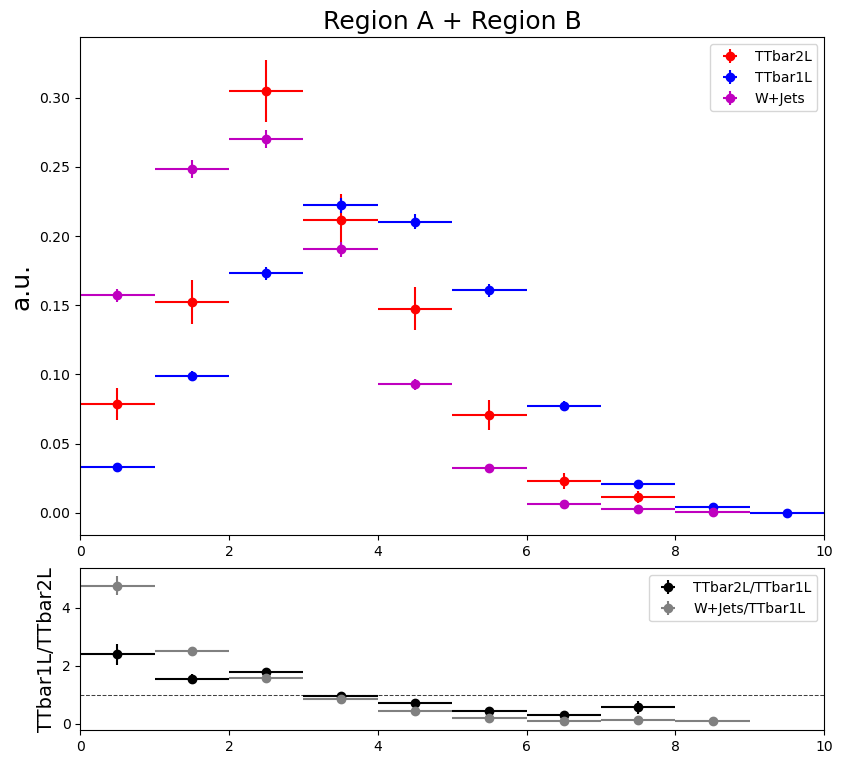

In [35]:
selection = "(regionA or regionB)"
bins = np.linspace(0, 10, 11)

fig = plt.figure(figsize=(6.4*1.5, 4.8*1.25*1.5))
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.1)
hist_axes = fig.add_subplot(gs[0])
ratio_axes = fig.add_subplot(gs[1])


tt1l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar1L'")
tt2l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar2L'")
wjets_df = vbswh.bkg_df(selection=f"{selection} and name == 'WJets'")

tt1l_hist = yahist.Hist1D(
    np.abs(tt1l_df.deta_jj.values),
    bins=bins,
    color="b",
    label="TTbar1L"
).normalize()
tt2l_hist = yahist.Hist1D(
    np.abs(tt2l_df.deta_jj.values),
    bins=bins,
    color="r",
    label="TTbar2L"
).normalize()
wjets_hist = yahist.Hist1D(
    np.abs(wjets_df.deta_jj.values),
    bins=bins,
    color="m",
    label="W+Jets"
).normalize()
ratio_hist = tt1l_hist/tt2l_hist

tt2l_hist.plot(ax=hist_axes, errors=True)
tt1l_hist.plot(ax=hist_axes, errors=True)
wjets_hist.plot(ax=hist_axes, errors=True)
(tt2l_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="k", label="TTbar2L/TTbar1L")
(wjets_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="grey", label="W+Jets/TTbar1L")

hist_axes.set_ylabel("a.u.", size=18)
hist_axes.set_title("Region A + Region B", size=18);

ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
# ratio_axes.legend().remove()
ratio_axes.set_ylabel("TTbar1L/TTbar2L", size=14);

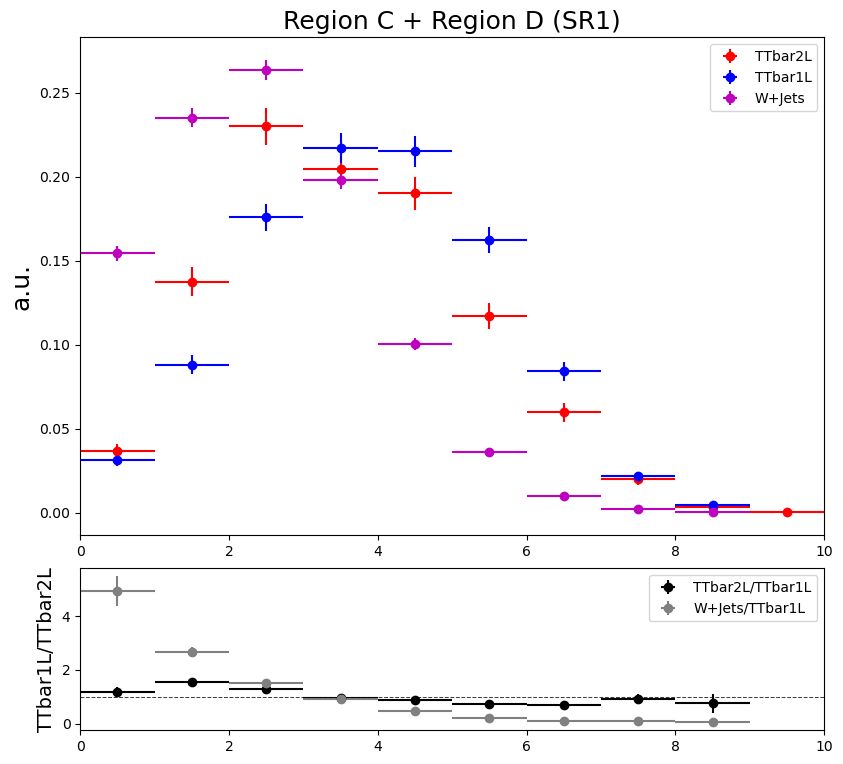

In [36]:
selection = "(regionC or SR1)"
bins = np.linspace(0, 10, 11)

fig = plt.figure(figsize=(6.4*1.5, 4.8*1.25*1.5))
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.1)
hist_axes = fig.add_subplot(gs[0])
ratio_axes = fig.add_subplot(gs[1])


tt1l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar1L'")
tt2l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar2L'")
wjets_df = vbswh.bkg_df(selection=f"{selection} and name == 'WJets'")

tt1l_hist = yahist.Hist1D(
    np.abs(tt1l_df.deta_jj.values),
    bins=bins,
    color="b",
    label="TTbar1L"
).normalize()
tt2l_hist = yahist.Hist1D(
    np.abs(tt2l_df.deta_jj.values),
    bins=bins,
    color="r",
    label="TTbar2L"
).normalize()
wjets_hist = yahist.Hist1D(
    np.abs(wjets_df.deta_jj.values),
    bins=bins,
    color="m",
    label="W+Jets"
).normalize()
ratio_hist = tt1l_hist/tt2l_hist

tt2l_hist.plot(ax=hist_axes, errors=True)
tt1l_hist.plot(ax=hist_axes, errors=True)
wjets_hist.plot(ax=hist_axes, errors=True)
(tt2l_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="k", label="TTbar2L/TTbar1L")
(wjets_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="grey", label="W+Jets/TTbar1L")

hist_axes.set_ylabel("a.u.", size=18)
hist_axes.set_title("Region C + Region D (SR1)", size=18);

ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
# ratio_axes.legend().remove()
ratio_axes.set_ylabel("TTbar1L/TTbar2L", size=14);

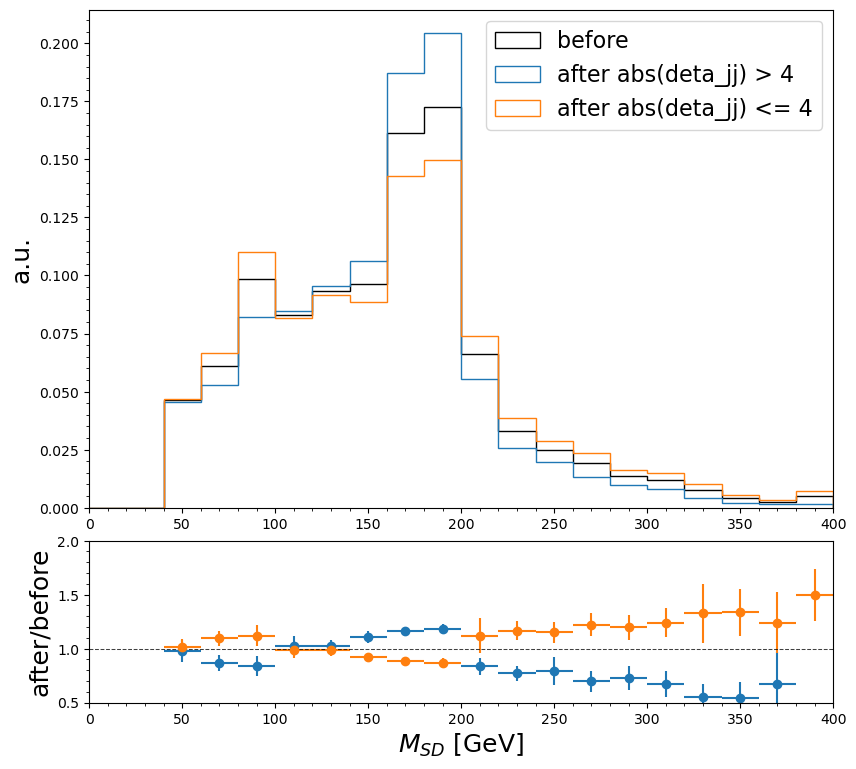

In [44]:
vbswh.plot_correlation(
    "hbbjet_msoftdrop", 
    np.linspace(0, 400, 21), 
    selections=[
        "abs(deta_jj) > 4",
        "abs(deta_jj) <= 4"
    ],
    base_selection="presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9",
    x_label="$M_{SD}$ [GeV]",
);

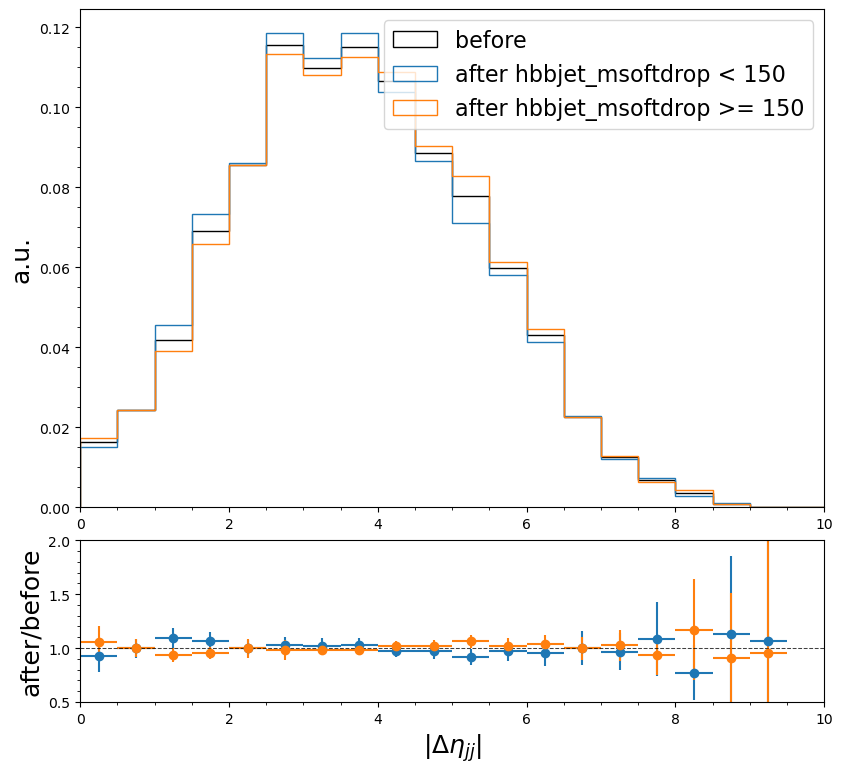

In [45]:
vbswh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 21),  
    selections=[
        "hbbjet_msoftdrop < 150",
        "hbbjet_msoftdrop >= 150"
    ], 
    base_selection="presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

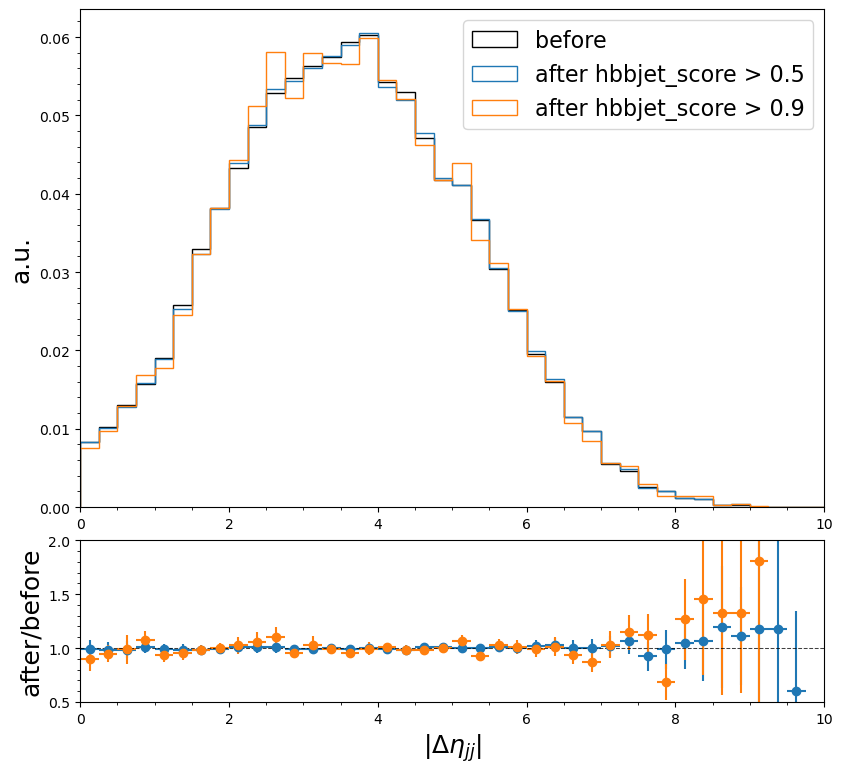

In [46]:
vbswh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 41),  
    selections=[
        "hbbjet_score > 0.5",
        "hbbjet_score > 0.9"
    ], 
    base_selection="presel_noDetaJJ and hbbjet_msoftdrop >= 150",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

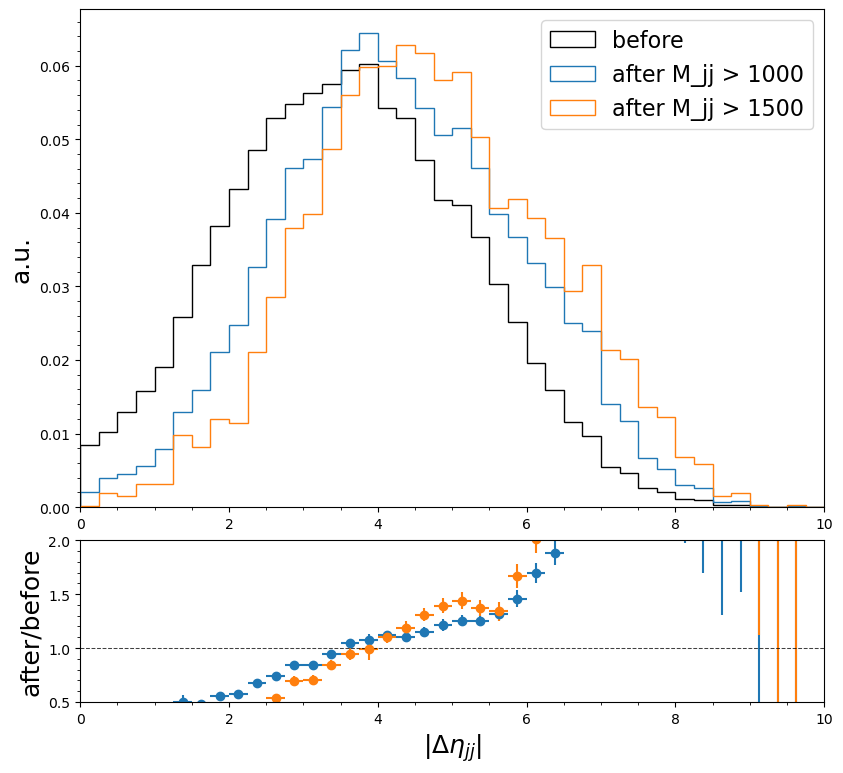

In [47]:
vbswh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 41),  
    selections=[
        "M_jj > 1000",
        "M_jj > 1500"
    ], 
    base_selection="presel_noDetaJJ and hbbjet_msoftdrop >= 150",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

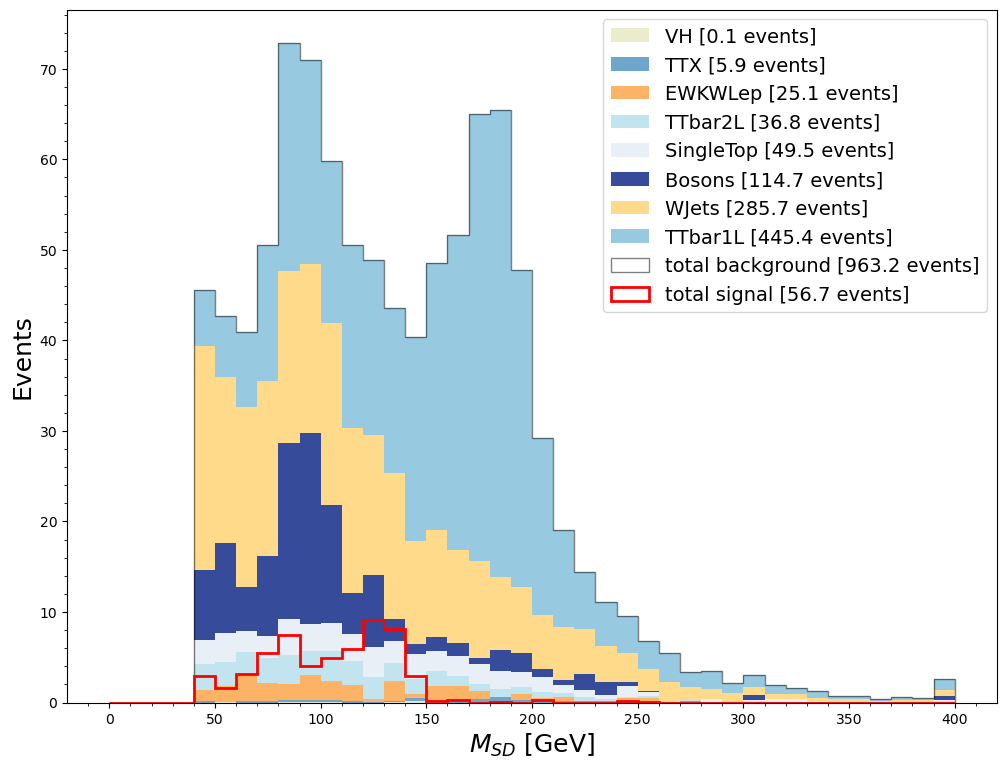

In [48]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_msoftdrop", np.linspace(0, 400, 41), 
    selection="presel and hbbjet_score < 0.6",
    x_label="$M_{SD}$ [GeV]",
    stacked=True,
#     norm=True
);
axes.set_ylim(ymin=0);

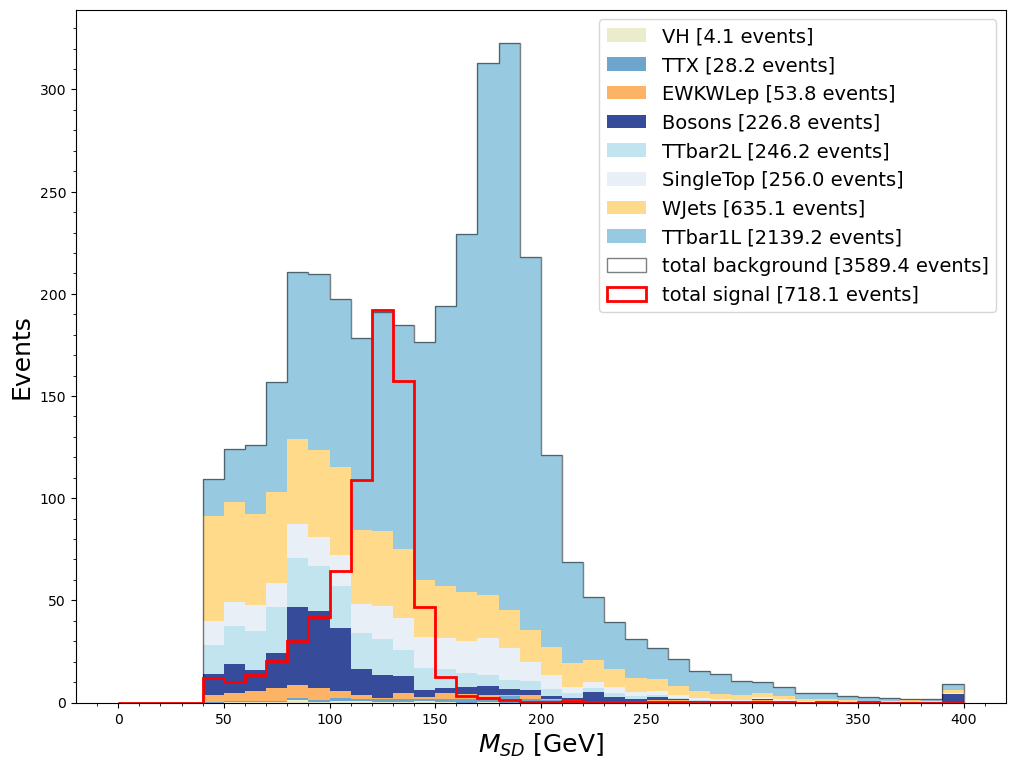

In [49]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_msoftdrop", np.linspace(0, 400, 41), 
    selection="presel",
    x_label="$M_{SD}$ [GeV]",
    stacked=True,
#     norm=True
);
axes.set_ylim(ymin=0);

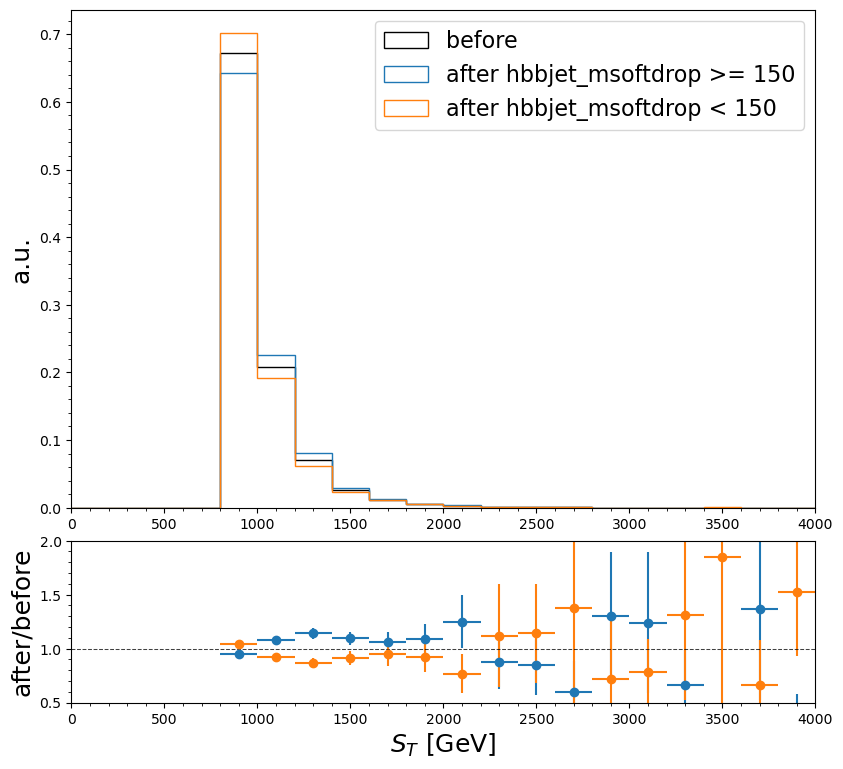

In [50]:
vbswh.plot_correlation(
    "ST", 
    np.linspace(0, 4000, 21),  
    selections=[
        "hbbjet_msoftdrop >= 150",
        "hbbjet_msoftdrop < 150"
    ], 
    base_selection="presel",
    x_label=r"$S_T$ [GeV]"
);

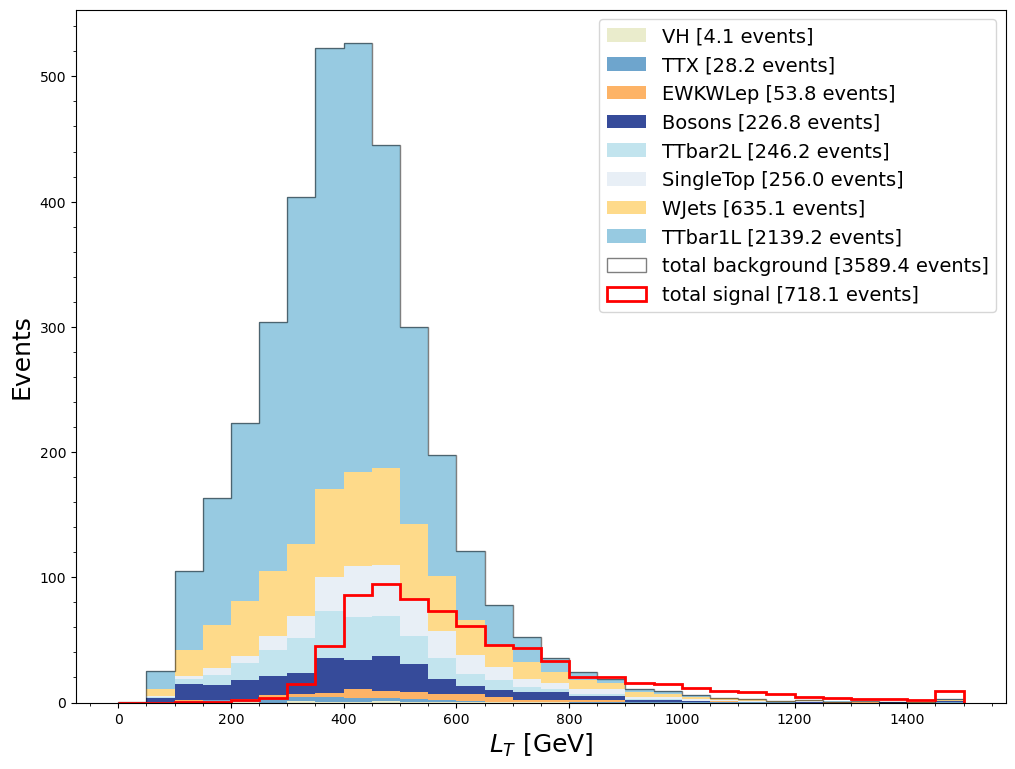

In [51]:
axes = vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 1500, 31), 
    selection="presel",
    x_label="$L_T$ [GeV]",
    stacked=True,
#     norm=True
);
axes.set_ylim(ymin=0);

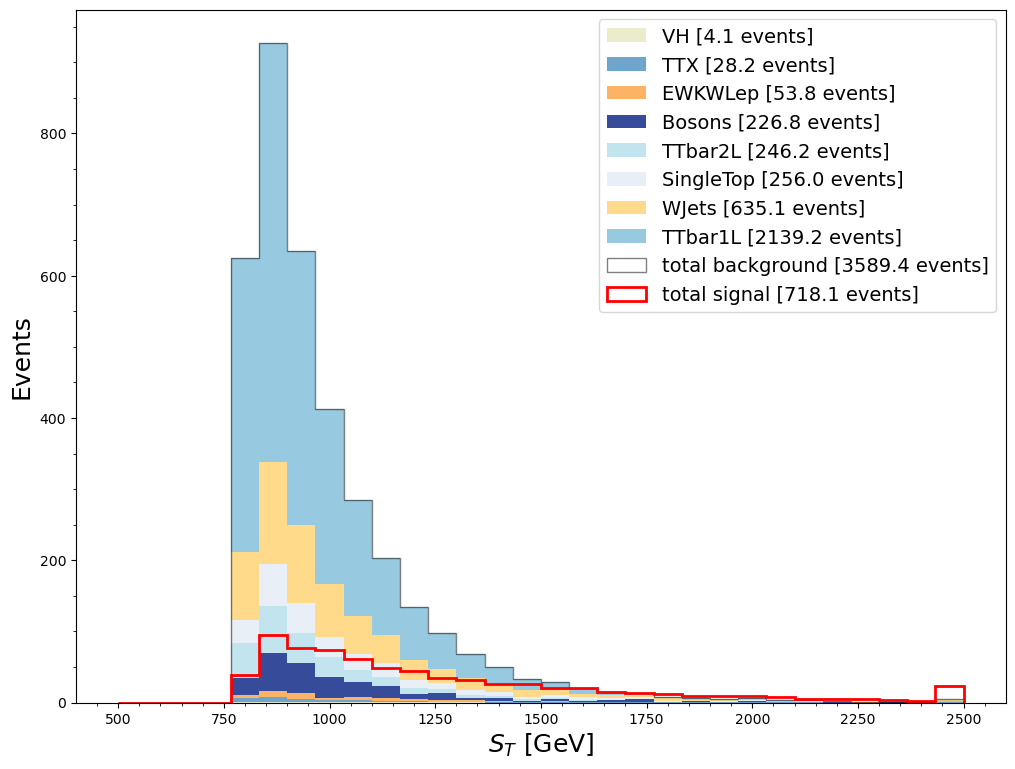

In [52]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(500, 2500, 31), 
    selection="presel",
    x_label="$S_T$ [GeV]",
    stacked=True,
#     norm=True
);
axes.set_ylim(ymin=0);

In [68]:
vbswh.get_event_counts(selection="presel and hbbjet_msoftdrop >= 150")

(21.969388615483677, 1724.3209584471651)

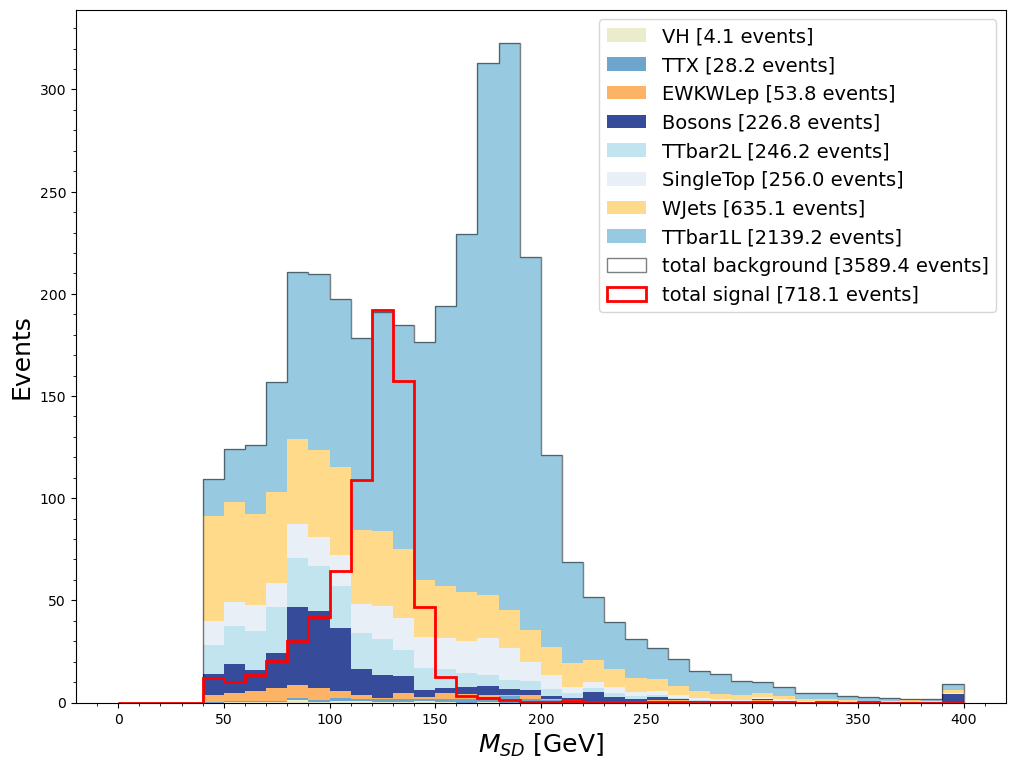

In [53]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_msoftdrop", np.linspace(0, 400, 41), 
    selection="presel",
    x_label="$M_{SD}$ [GeV]",
    stacked=True,
#     norm=True
);
# axes.set_ylim(ymin=0);

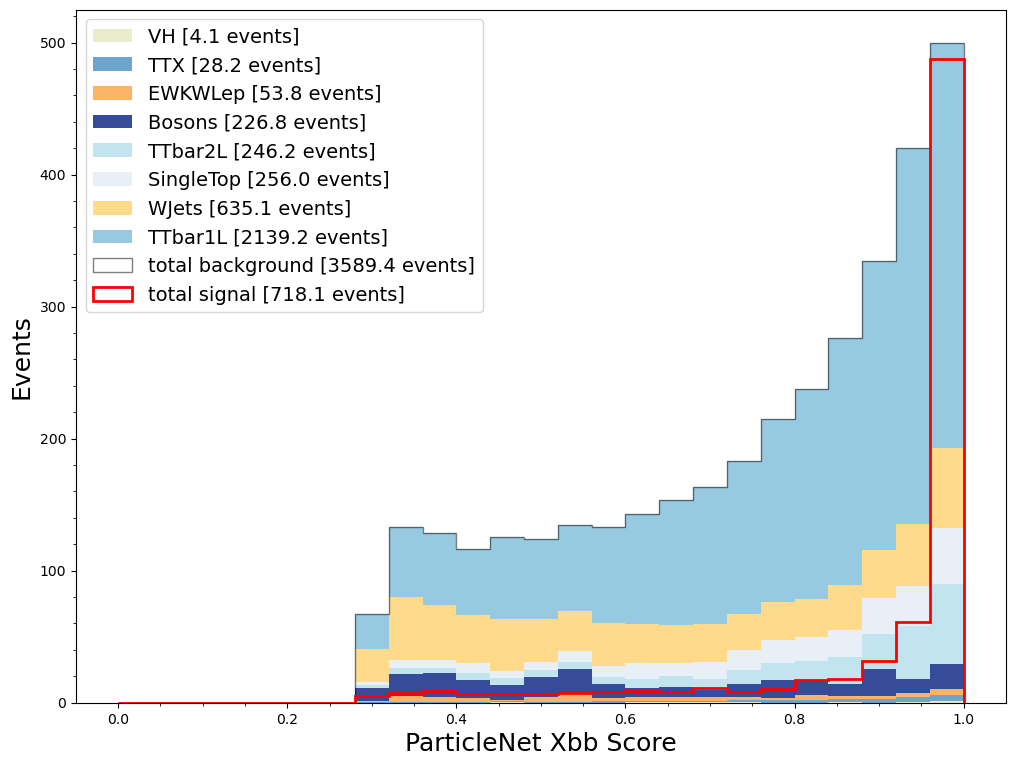

In [66]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_score", np.linspace(0, 1, 26), 
    selection="presel",
    x_label="ParticleNet Xbb Score",
    stacked=True,
#     norm=True
);
axes.set_ylim(ymin=0);
axes.legend(loc=2, fontsize=14);

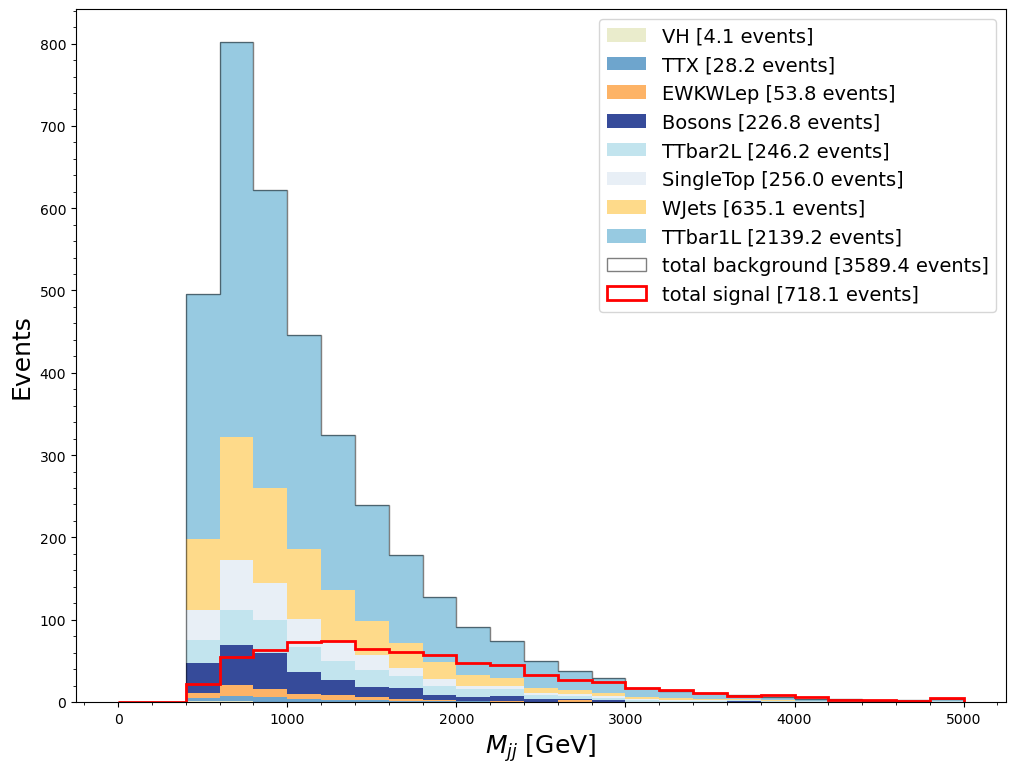

In [55]:
axes = vbswh.plot_sig_vs_bkg(
    "M_jj", np.linspace(0, 5000, 26), 
    selection="presel",
    x_label="$M_{jj}$ [GeV]",
    stacked=True,
#     norm=True,
#     logy=True
);
axes.set_ylim(ymin=0);

In [67]:
vbswh.get_event_counts(selection="presel_noDetaJJ and abs(deta_jj) <= 3")

(8.119865027819142, 2032.9249888058876)

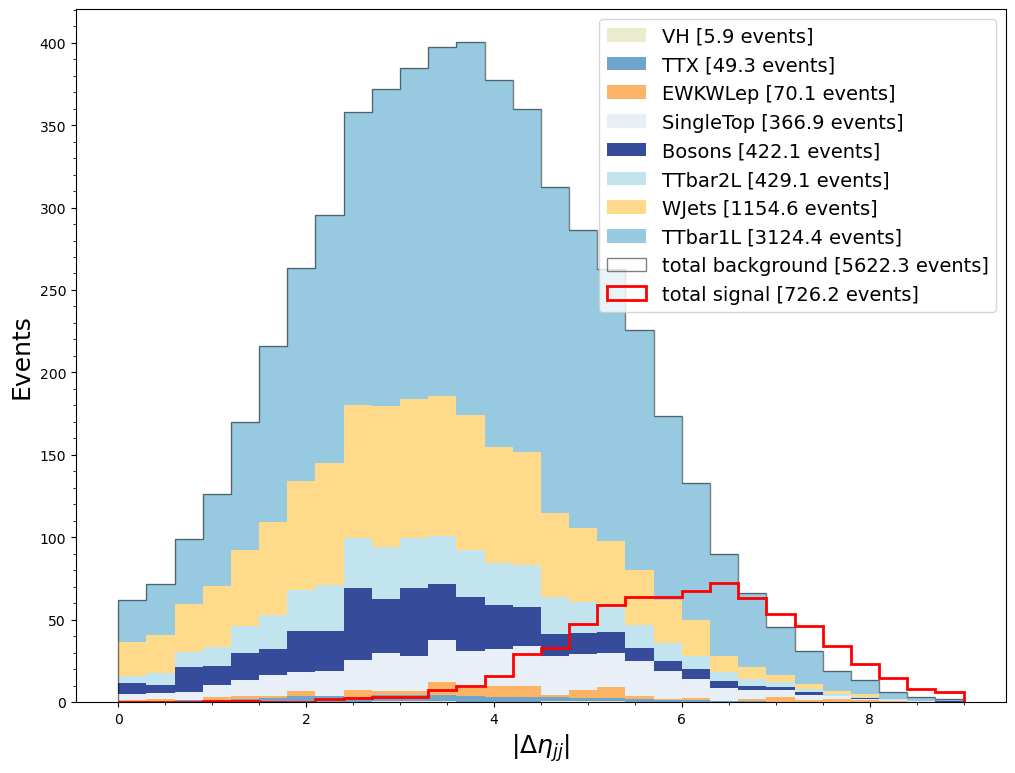

In [57]:
axes = vbswh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 9, 31), 
    selection="presel_noDetaJJ", 
    x_label="$|\Delta\eta_{jj}|$",
    transf=abs,
    stacked=True
);

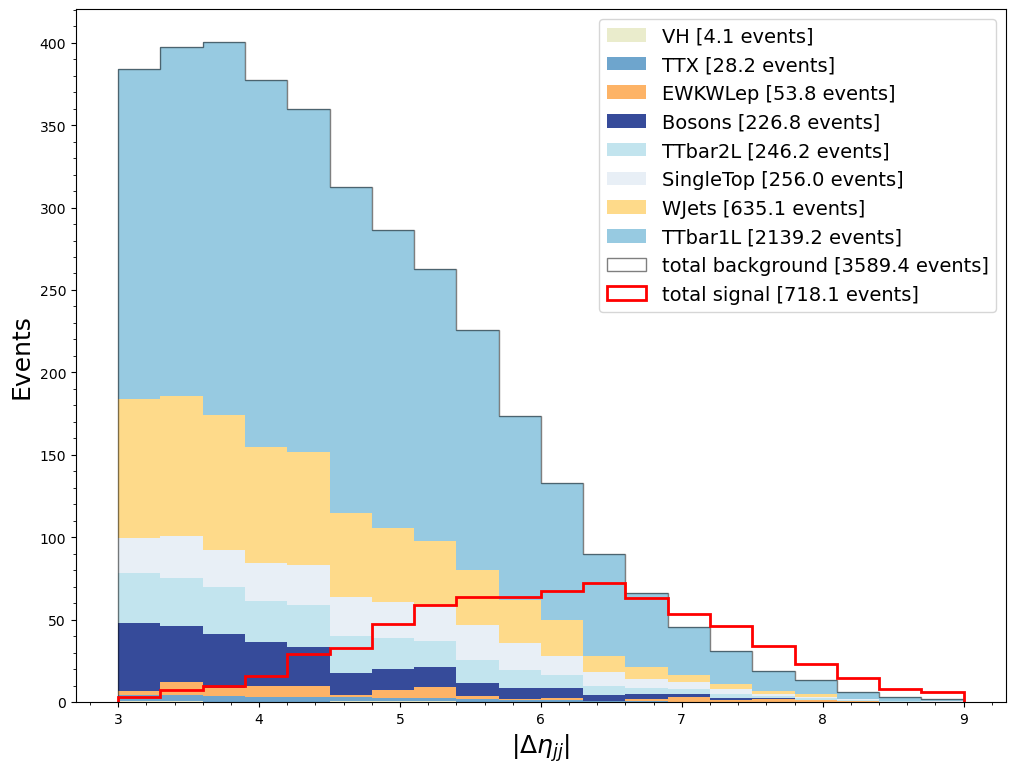

In [58]:
axes = vbswh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(3, 9, 21), 
    selection="presel", 
    x_label="$|\Delta\eta_{jj}|$",
    transf=abs,
    stacked=True
);
# axes.legend(loc=2, fontsize=14);

In [59]:
vbswh.fom_scan(
    "deta_jj", [3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7], operator=">", 
    base_selection="M_jj > 1500", abs=True
)

sel,sig,bkg,fom
M_jj > 1500,641.972633089132,6102.552630202753,8.217898027040738
M_jj > 1500 and abs(deta_jj) > 3.5,639.6498660348669,4786.185993427372,9.245864564809658
M_jj > 1500 and abs(deta_jj) > 4,634.7684022045116,4181.079325626045,9.81682607068511
M_jj > 1500 and abs(deta_jj) > 4.5,623.287573514435,3468.430240290451,10.583321429289853
M_jj > 1500 and abs(deta_jj) > 5,601.4452787382996,2687.9431193459936,11.600750408168519
M_jj > 1500 and abs(deta_jj) > 5.5,558.1890924577729,1965.1874451291185,12.59155466453094
M_jj > 1500 and abs(deta_jj) > 6,482.8740953623913,1367.1886957035872,13.059293367555284
M_jj > 1500 and abs(deta_jj) > 6.5,370.58393029704337,906.8401295225265,12.306122044798332
M_jj > 1500 and abs(deta_jj) > 7,248.77134224422412,541.849136332187,10.687131585143678


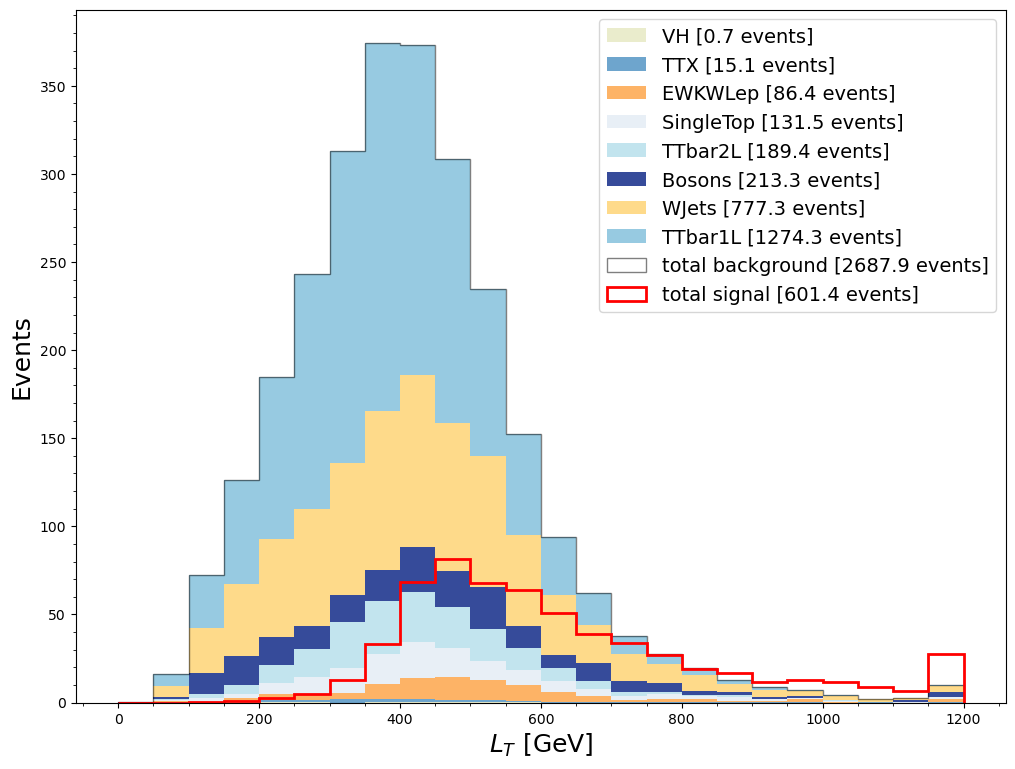

In [60]:
vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 1200, 25), 
    selection="M_jj > 1500 and abs(deta_jj) > 5", 
    x_label="$L_T$ [GeV]",
    stacked=True
);

In [61]:
vbswh.fom_scan(
    "LT", [500, 600, 700, 800, 900, 1000, 1100, 1200], operator=">", 
    base_selection="M_jj > 1500 and abs(deta_jj) > 5"
);

sel,sig,bkg,fom
M_jj > 1500 and abs(deta_jj) > 5,601.4452787382996,2687.9431193459936,11.600750408168519
M_jj > 1500 and abs(deta_jj) > 5 and LT > 500,396.5062091513495,675.6069119487807,15.254674688007897
M_jj > 1500 and abs(deta_jj) > 5 and LT > 600,265.3162733919485,288.7222867548692,15.614343681004687
M_jj > 1500 and abs(deta_jj) > 5 and LT > 700,175.40869532494077,132.4909132491842,15.239056228181264
M_jj > 1500 and abs(deta_jj) > 5 and LT > 800,114.65825710621496,67.18323506118682,13.988620221396731
M_jj > 1500 and abs(deta_jj) > 5 and LT > 900,78.74306416322983,35.02544087331124,13.305172374217475
M_jj > 1500 and abs(deta_jj) > 5 and LT > 1000,54.42706681048705,19.160997845971345,12.433857016352727
M_jj > 1500 and abs(deta_jj) > 5 and LT > 1100,33.96192492182187,12.692640088627071,9.532708541648573
M_jj > 1500 and abs(deta_jj) > 5 and LT > 1200,22.383325688191402,7.778383353139796,8.025644939342957


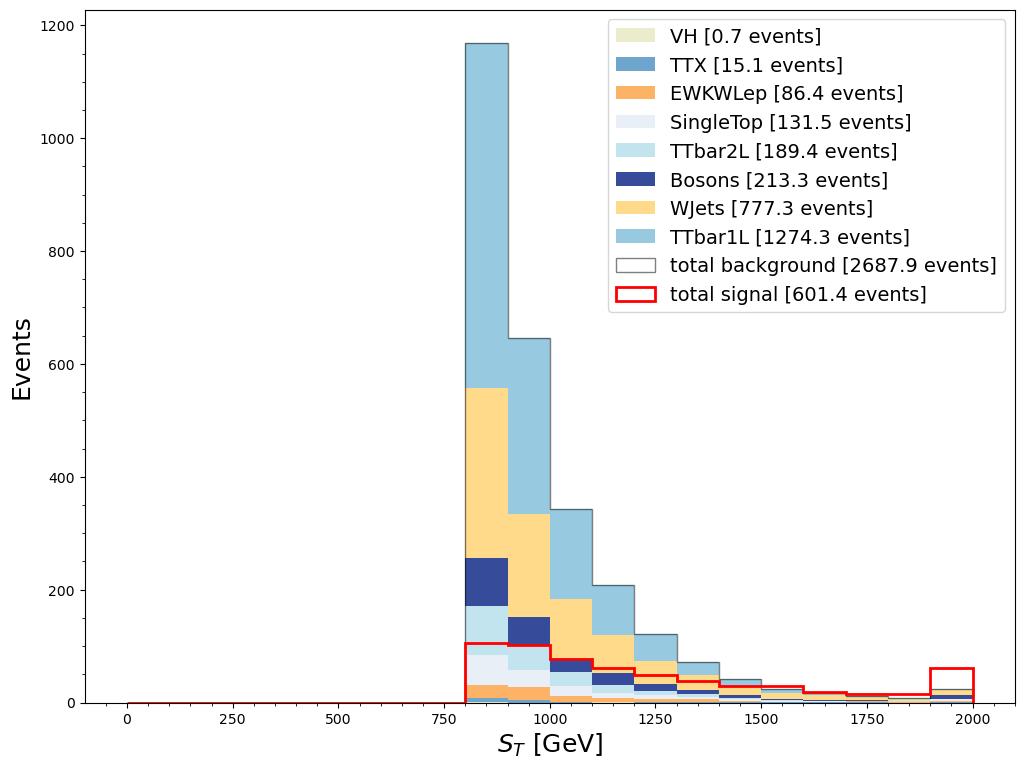

In [62]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(0, 2000, 21), 
    selection="M_jj > 1500 and abs(deta_jj) > 5", x_label="$S_T$ [GeV]",
    stacked=True
);
axes.set_ylim(ymin=0);

In [63]:
vbswh.fom_scan(
    "ST", [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1650, 1700, 1800], operator=">", 
    base_selection="M_jj > 1500 and abs(deta_jj) > 5"
)

sel,sig,bkg,fom
M_jj > 1500 and abs(deta_jj) > 5,601.4452787382996,2687.9431193459936,11.600750408168519
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1000,393.9553915593899,872.744321028769,13.335322795881456
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1100,317.6613984345596,529.989716053887,13.798463278803835
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1200,256.7777314744569,321.83101007071036,14.313419953062562
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300,207.55903881153222,200.59246637575978,14.654950022835523
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1400,168.96461479505058,128.19341360121456,14.923232540043635
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1500,140.30007234142477,85.7885641119274,15.147577930905646
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1600,111.8250546661782,61.654066315523345,14.2415827134745
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1650,102.01348172329486,52.2347014213354,14.114906707193956
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1700,92.46167705407188,44.305181298

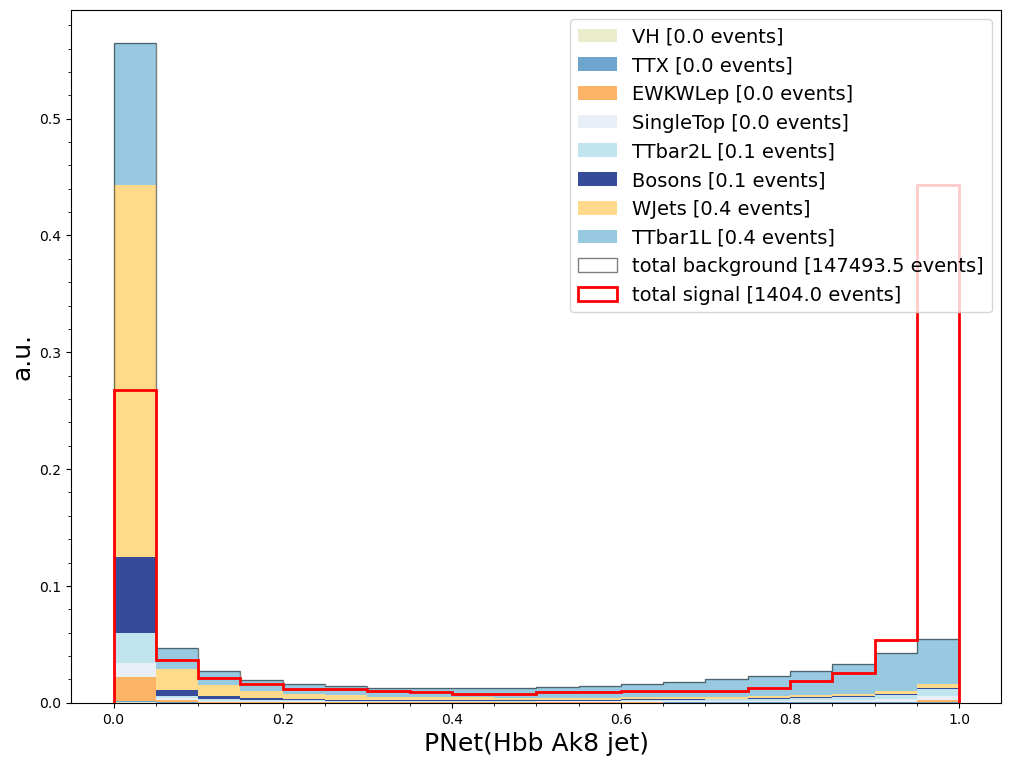

In [64]:
vbswh.plot_sig_vs_bkg(
    "hbbjet_score", np.linspace(0, 1.0, 21), 
#     selection="M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300", 
    x_label="PNet(Hbb Ak8 jet)",
    stacked=True,
    norm=True
);

In [65]:
vbswh.fom_scan(
    "hbbjet_score", np.linspace(0.91, 0.99, 9), operator=">", 
    base_selection="M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300"
)

sel,sig,bkg,fom
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300,207.55903881153222,200.59246637575978,14.654950022835523
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.91,109.62438378629011,16.10863348286168,27.313528935800235
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.92,107.68376997210768,14.41282538639885,28.364536360278368
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.93,105.42481475874342,12.986020518280153,29.25531672343994
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.9400000000000001,103.53762194166018,11.613924175535752,30.381463664714794
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.95,100.47210560256363,10.132588513998137,31.56351058989045
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.96,97.19974006327077,8.387678623231906,33.56172020891543
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.97,92.25347537910868,6.45852112981836